In [54]:
%matplotlib inline
import sys
from astropy import table
import numpy as np
from pathlib import Path
from matplotlib import colors, cm
import cmocean
import betterplotlib as bpl

bpl.set_style()

In [39]:
home_dir = Path("../").resolve()
data_dir = home_dir / "data"

In [40]:
sys.path.append(str(home_dir / "pipeline"))
import utils

In [41]:
calzetti_path = home_dir / "analysis" / "calzetti_etal_15_table_1.txt"
galaxy_table = table.Table.read(
    calzetti_path, format="ascii.commented_header", header_start=3
)

In [42]:
distances = []
ssfrs = []
numbers = []
catalogs = defaultdict(dict)
for galaxy_dir in data_dir.iterdir():
    distances.append(utils.distance(galaxy_dir).to("Mpc").value)
    
    this_galaxy = galaxy_dir.name.split("-")[0].upper()
    for row in galaxy_table:
        if row["name"] == this_galaxy:
            ssfrs.append(row["sfr_uv_msun_per_year"] / row["m_star"])
            
    cat_name = galaxy_dir / "size" / "final_catalog_final_30_pixels_psf_my_stars_15_pixels_2x_oversampled.txt"
    final_cat = table.Table.read(str(cat_name), format="ascii.ecsv")
    numbers.append(len(final_cat))

In [66]:
cluster_distances = []
cluster_ssfrs = []
for idx in range(len(distances)):
    cluster_distances += [distances[idx]] * numbers[idx]
    cluster_ssfrs += [ssfrs[idx]] * numbers[idx]
    
median_dist = np.median(cluster_distances)
median_ssfr = np.median(cluster_ssfrs)

In [72]:
# find the amount in each quadrant
n_top_right    = np.sum(np.logical_and(cluster_distances > median_dist, cluster_ssfrs > median_ssfr))
n_top_left     = np.sum(np.logical_and(cluster_distances < median_dist, cluster_ssfrs > median_ssfr))
n_bottom_right = np.sum(np.logical_and(cluster_distances > median_dist, cluster_ssfrs < median_ssfr))
n_bottom_left  = np.sum(np.logical_and(cluster_distances < median_dist, cluster_ssfrs < median_ssfr))

In [68]:
cmap = cmocean.cm.haline_r
norm = colors.LogNorm(vmin=10, vmax=3e3)
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

plot_colors = mappable.to_rgba(numbers)

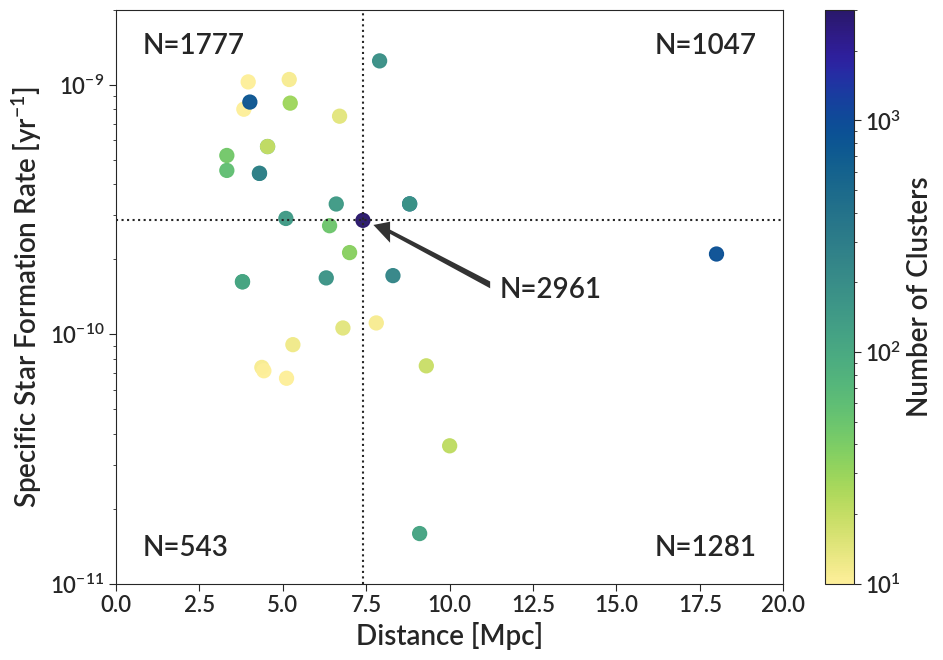

In [126]:
fig, ax = bpl.subplots()
ax.scatter(distances, ssfrs, s=100, c=plot_colors)
ax.set_yscale("log")
ax.add_labels("Distance [Mpc]", "Specific Star Formation Rate [yr$^{-1}$]")
ax.axvline(median_dist, ls=":")
ax.axhline(median_ssfr, ls=":")
ax.easy_add_text(f"N={n_top_right}", "upper right")
ax.easy_add_text(f"N={n_top_left}", "upper left")
ax.easy_add_text(f"N={n_bottom_right}", "lower right")
ax.easy_add_text(f"N={n_bottom_left}", "lower left")
ax.arrow(x=median_dist*1.11 + 3, dx=-3, y=median_ssfr*0.9 - 1e-10, dy=1e-10,
        width=1e-11, head_width=5e-11, head_length=0.5, lw=0, color="0.2")
ax.add_text(11.5, 1.4e-10, f"N={max(numbers)}")
ax.set_limits(0, 20, 1e-11, 2e-9)
cb = fig.colorbar(mappable, ax=ax)
cb.set_label("Number of Clusters")
fig.savefig("galaxy_properties.png")

In [ ]:
ax.plot([median_dist, x_label], [median_ssfr, y_label], c=bpl.almost_black, lw=1)